<a href="https://colab.research.google.com/github/felixsimard/comp551-p3/blob/main/HassanNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init()



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from google.colab import drive
from datetime import datetime
from PIL import Image
from sklearn import preprocessing
from tqdm import tqdm

import math
import string
import cv2

In [ ]:
# Device configuration
drive.mount("/content/drive")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda:0


In [ ]:
PATH = './cnn.pth'

## Utility Functions


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def load_data(filename, data_path="/content/drive/MyDrive/data/"):
    loaded_pkl = None
    try:
        pkl_buffered = open(data_path+''+filename,'rb')
        loaded_pkl = pickle.load(pkl_buffered)
    except Exception as e:
        print("Error loading data: {}".format(e))
    return loaded_pkl

In [ ]:
alpha_dict = dict(enumerate(string.ascii_lowercase))
def get_label_value(labels):
  """
  This function will return a string representing the label of a picture given
  the array label as input:
  Ex ouput: '1a', '4z' ...
  """
  label_temp = labels.tolist()
  label_temp = [int(x) for x in label_temp]
  number = label_temp[:10].index(1)
  letter = alpha_dict[label_temp[10:].index(1)]

  return str(number) + str(letter)

In [ ]:
# Methods to calculate some accuracy metrics
def convert_outputs_to_preds(outputs):
    preds = np.empty(shape=(len(outputs), 36))
    for i, output in enumerate(outputs):
        pred = np.zeros(36)
        digit_index = np.argmax(output[:11])
        letter_index = np.argmax(output[11:]) + 11
        pred[digit_index], pred[letter_index] = 1, 1
        preds[i] = pred
    return preds
    
def correct_digits(preds, labels):
    return np.map((preds, labek))

def correct_letters(preds, labels):
    return np.array_equal(pred[11:],label[11:])

def get_accuracy(preds, labels):
    preds_str = convert_labels_to_strings(preds)
    labels_str = convert_labels_to_strings(labels)
    correct_preds = np.equal(preds_str, labels_str)
    return correct_preds.sum() / len(labels)

def check_prediction(preds, labels):
    return np.equal(preds, labels)

def print_model_weights(model):
    for name, param in model.named_parameters():
      print(name, param.size())    

def convert_labels_to_strings(labels):
  result = np.empty(len(labels)).astype('object')
  for i, pred in enumerate(labels):
    prediction = ''
    for elem in pred:
      prediction = prediction + str(int(elem))
    result[i] = prediction
  return result

In [ ]:
# Reference: https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
class MyDataset(Dataset):
    def __init__(self, data, targets=None, transform=None, transform_target=None):
        self.data = torch.from_numpy(data).float()
        self.targets = torch.from_numpy(targets).float() if targets is not None else None
        self.transform = transform
        self.transform_target = transform_target
        
    def __getitem__(self, index):
        x = self.data[index]
        y = np.zeros(36, dtype=float)# self.targets[index]

        if self.targets is not None:
            y = self.targets[index]
        else:
            None
        if self.transform:
            x = self.transform(x)
        if self.transform_target:
            y = self.transform_target(y)
        
        return x, y
    
    
    def __len__(self):
        return len(self.data)

## Hyperparameters

In [ ]:
# Hyper-parameters
epochs = 30
batch_size = 16
channels = 1
classes = 36
alpha = 0.007
beta = 0.9
gamma = 0.0001
train_valid_split = 0.3

## Pickle Data to Numpy NDArray

In [ ]:
# loading all data
train_features = load_data("images_l.pkl")[:, None]
train_labels = load_data("labels_l.pkl")
test = load_data("images_test.pkl")[:, None]
train_unlabelled = load_data("images_ul.pkl")[:, None]

In [ ]:
print(train_features.shape, train_features[:1])
print(train_labels.shape, train_labels[:1])

(30000, 1, 56, 56) [[[[  0.   0.   0. ... 175.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]
   [  0.   0.   0. ...   0. 175.   0.]
   ...
   [  0.   0.   0. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]
   [  0.   0.   0. ...   0.   0.   0.]]]]
(30000, 36) [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
for data in [train_features, train_labels, train_unlabelled, test]:  
  print(type(data) is np.ndarray)

True
True
True
True


## Training & Validation Split

In [ ]:
split_index = math.floor(len(train_labels)*train_valid_split)

full_train_l = train_features
val_l = train_features[:split_index]
train_l = train_features[split_index:]

full_train_labels_l = train_labels
val_labels_l = train_labels[:split_index]
train_labels_l = train_labels[split_index:]

print(full_train_l.shape, full_train_labels_l.shape)
print(train_l.shape, train_labels_l.shape)
print(val_l.shape, val_labels_l.shape)

(30000, 1, 56, 56) (30000, 36)
(21000, 1, 56, 56) (21000, 36)
(9000, 1, 56, 56) (9000, 36)


## Image Data Augmentation (Preprocessing Part I)

Text(0.5, 1.0, 'distribution of pixels')

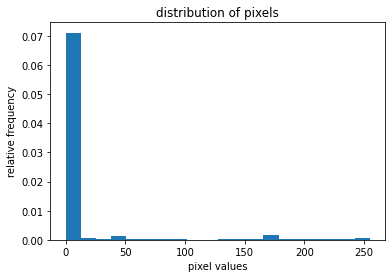

In [ ]:
img_pil = train_l[1189]
plt.hist(np.array(img_pil).ravel(), bins=20,density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [ ]:
def ImageTransformer(transforms: list)->None:

  Transform = tv.transforms.Compose(transforms)

  dl = DataLoader(MyDataset(train_l, train_labels_l, 
                  transform=Transform), shuffle=True, batch_size=batch_size)
  
  figure = plt.figure(figsize=(5,5))
  sample_idx = torch.randint(len(dl), size=(1,)).item()
  img = train_l[sample_idx]
  label = get_label_value(train_labels_l[sample_idx])
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze())

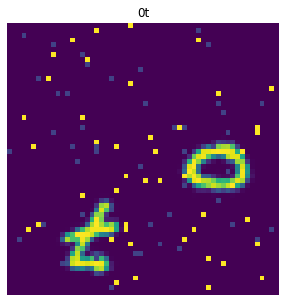

In [ ]:
input = [tv.transforms.RandomHorizontalFlip(p=0.5)]
ex = ImageTransformer(input)

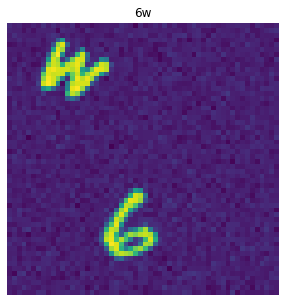

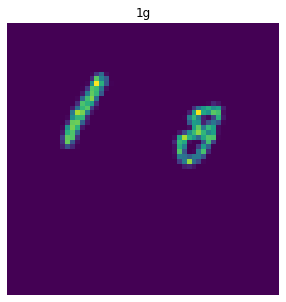

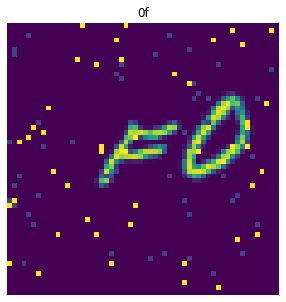

In [ ]:
i = [         transforms.Normalize(mean=(0.5,), std=(0.5,)),
              tv.transforms.RandomResizedCrop([56,56]),
              tv.transforms.RandomRotation(60),
              tv.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3)]

for _ in range(3): ImageTransformer(i)

In [ ]:
# Color, brightness shift
T1 = transforms.Compose([         transforms.Normalize(mean=(0.5,), std=(0.5,)),
                                  tv.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3)
                                  ])
# Random rotation, padding
T2 = transforms.Compose([         transforms.Normalize(mean=(0.5,), std=(0.5,)),
                                  tv.transforms.RandomRotation(60),
                                  #transforms.Pad(25, padding_mode='symmetric')
                                  ])
# Random horizontal flipping
T3 = transforms.Compose([         transforms.Normalize(mean=(0.5,), std=(0.5,)),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  ])
# Randome verticle flipping
T4 = transforms.Compose([         transforms.Normalize(mean=(0.5,), std=(0.5,)),
                                  transforms.RandomVerticalFlip(p=0.5),
                                  ])
noT = transforms.Compose([         transforms.Normalize(mean=(0.5,), std=(0.5,))])

## Tensor DataLoader & Feature Labels (Preprocessing Part II)

* Transforms will be applied to the dataset in the following scheme: 
   * 50% of the data will be untouched
   * The other 50% will be split between 4 different image augmentations
   * DataSet: 50% untransformed, 4*6.25% transformed segments

In [ ]:
#7500: 0:1876->  1876:3751-> 3751:5626 -> 5626:7501 
'''d_T1 = MyDataset(train_l[0:3751], train_labels_l[0:3751], transform=T1)
d_T2 = MyDataset(train_l[3751:7501], train_labels_l[3751:7501], transform=T2)
d_T3 = MyDataset(train_l[7501:11251], train_labels_l[7501:11251], transform=T3)
d_T4 = MyDataset(train_l[11251:15001], train_labels_l[11251:15001], transform=T4)
d_noT = MyDataset(train_l[15001:30001], train_labels_l[15001:30001], transform=noT)'''

d_T1 = MyDataset(train_l[0:1876], train_labels_l[0:1876], transform=T1)
d_T2 = MyDataset(train_l[1876:3751], train_labels_l[1876:3751], transform=T2)
d_T3 = MyDataset(train_l[3751:5626], train_labels_l[3751:5626], transform=T3)
d_T4 = MyDataset(train_l[5626:7501], train_labels_l[5626:7501], transform=T4)
d_noT = MyDataset(train_l[7501:30001], train_labels_l[7501:30001], transform=noT)

training_full = torch.utils.data.ConcatDataset([d_T1, d_T2, d_T3, d_T4, d_noT])

In [ ]:
# DataLoaders
all_training = DataLoader(MyDataset(full_train_l, full_train_labels_l, 
                                                   transform=None), shuffle=True, batch_size=batch_size)
training = DataLoader(training_full, shuffle=True, batch_size=batch_size)
validation = DataLoader(MyDataset(val_l, val_labels_l, 
                                                   transform=None), shuffle=True)

# TODO: add unlabelled training data

# Test set for Kaggle
test_labels_ul = np.zeros(len(test))
testing = DataLoader(MyDataset(test, test_labels_ul, 
                                                    transform=None), batch_size=batch_size, shuffle=False)

print(len(all_training)*batch_size,len(training)*batch_size, len(testing)*batch_size)

In [ ]:
imgs, labels = next(iter(training))

imshow(tv.utils.make_grid(imgs.cpu()))

## CNN (AlexNet)

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels=channels, num_classes=classes):
        super().__init__() # invoke the parent constructor
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=5, padding=2), # (b_sz, 1, 56, 56) --> (b_sz, 16, 56, 56)
            nn.MaxPool2d(2), # (b_sz, 32, 56, 56) --> (b_sz, 32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (b_sz, 32, 28, 28) --> (b_sz, 64, 28, 28)
            nn.MaxPool2d(2), # (b_sz, 64, 28, 28) --> (b_sz, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (b_sz, 64, 14, 14) --> (b_sz, 128, 14, 14)
            #nn.MaxPool2d(2), # (b_sz, 128, 14, 14) --> (b_sz, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 84, kernel_size=3, padding=1), # (b_sz, 128, 14, 14) --> (b_sz, 84, 14, 14)
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.Conv2d(84, 84, kernel_size=3, padding=1), # (b_sz, 84, 14, 14) --> (b_sz, 84, 14, 14),
            nn.BatchNorm2d(84),
            nn.ReLU()
        )
        self.maxpool = nn.AdaptiveMaxPool2d(output_size=(6, 6))
        self.dense_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(84*6*6, 1512),
            nn.BatchNorm1d(1512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1512, 1512),
            nn.BatchNorm1d(1512),
            nn.ReLU(),
            nn.Linear(1512, self.num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.maxpool(x)
        x = x.view(x.size()[0], -1)
        x = self.dense_block(x)
        return x

## Training & Evaluation Method

In [ ]:
# Train function
def train(model, dataloader=training):

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=alpha, momentum=beta, weight_decay=gamma)

    for epoch in range(epochs):
      running_loss = 0.0
      model.train()
      for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,targets)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
        if i % 100 == 99:    # print every 100 mini-batches
          print('epoch: %d Batch: %d loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
          running_loss = 0.0
    
    # DONE TRAINING
    print('Finished Training')
    torch.save(model.state_dict(), PATH)

In [ ]:
# Evaluation function
def eval_model(model, dl):
    accs, accs_d, accs_l = [], [], []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(dl):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = convert_outputs_to_preds(outputs.cpu().detach().numpy())
            preds_d = preds[:, :11]
            preds_l = preds[:, 11:]
            labels_d = labels[:, :11]
            labels_l = labels[:, 11:]
            accs.append(get_accuracy(preds, labels.cpu()))
            accs_d.append(get_accuracy(preds_d, labels_d.cpu()))
            accs_l.append(get_accuracy(preds_l, labels_l.cpu()))
    return sum(accs)/len(accs), sum(accs_d)/len(accs_d), sum(accs_l)/len(accs_l)

## Testing

In [ ]:
def transform_output(scores):
    """
    Input a Tensor and output will be another Tensor with same dimension but with all elements 0 except two.
    Those 2 elements will have value of 1 and will correspond to the models prediction about which letter and number
    is in the image.
    :param scores:
    :return:
    """
    return_array = []
    score_list = scores.tolist()

    for score in score_list:
        numbers = score[:10]
        letters = score[10:]
        test = lambda x, max_value : 1 if x >= max_value else 0

        new_numbers = [test(x, max(numbers)) for x in numbers]
        new_letters = [test(x, max(letters)) for x in letters]

        return_array.append(new_numbers + new_letters)

    return return_array

## Main()

In [ ]:
cnn = CNN().to(device)
train(cnn)

In [ ]:
eval_model(cnn, validation)

In [ ]:
df = pd.DataFrame(columns=['# Id', 'Category'])
#device = torch.device('cpu')
with torch.no_grad():
    i = 0
    for data in testing:
        inputs = inputs.to(device) 
        targets = targets.to(device)
        outputs = model(inputs)
        predictions = transform_output(outputs)
        for pred in predictions:
            label = ''.join(str(x) for x in pred)
            df.loc[i] = [i, label]
            i += 1

df = df.iloc[:15001]

df

In [ ]:
def makeMyCSV(dataf: pd.DataFrame)->None:
  filename = 'kaggle_g19_{}.csv'.format(datetime.now())
  dataf.to_csv(filename, sep=',', float_format='{:36}', index=False)

makeMyCSV(df)